In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, GaussianNoise, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
size = 256
channels = 1  #input image format
input_img = Input(shape=(size, size, channels))
#print(input_img)

In [3]:
#Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [4]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 1)    │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def preprocess_image(image):
    #resize image so they're same format
    image = cv2.resize(image, (size, size))
    # Apply Gaussian Blurring to smooth the image and reduce noise
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Create a kernel for morphological operations
    kernel = np.ones((10, 10), np.uint8)
    # Apply morphological opening to the image
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    # Normalize the image to have values between 0 and 1
    image = np.expand_dims(image, axis=-1) / 255.0
    return image

def custom_preprocessor(img):
    # Assuming 'img' is a NumPy array of image data
    return preprocess_image(img)

datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessor,
    validation_split=0.15
)


In [6]:
import os
os.getcwd()

'/Users/yong/Desktop/thesis'

In [6]:
train_generator = datagen.flow_from_directory(
    'experiment dataset',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    subset='training',
    shuffle = False
)
validation_generator = datagen.flow_from_directory(
    'experiment dataset',  #path to dataset
    target_size=(size, size),
    color_mode='grayscale',
    batch_size=32,
    class_mode='input',
    subset='validation'
)

Found 71 images belonging to 5 classes.
Found 11 images belonging to 5 classes.


In [23]:
train_generator.reset()

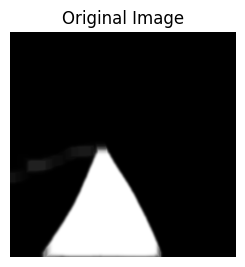

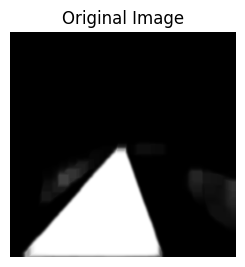

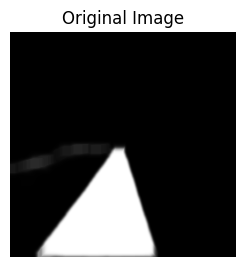

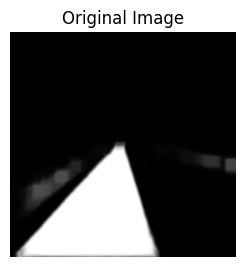

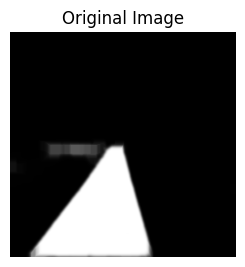

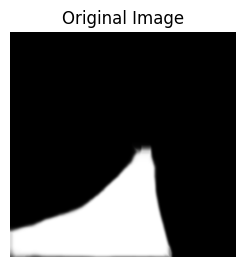

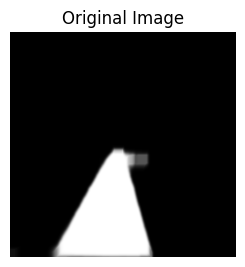

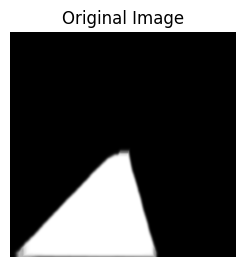

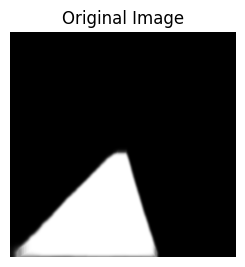

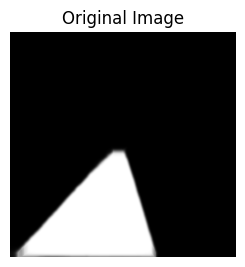

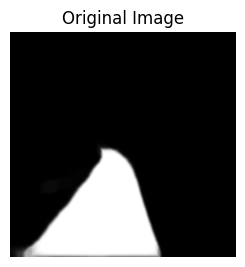

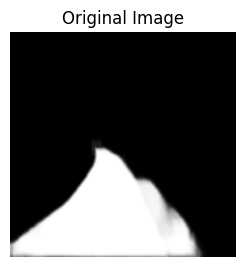

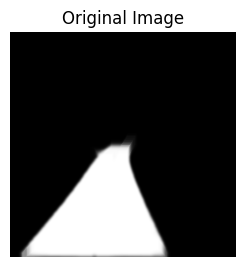

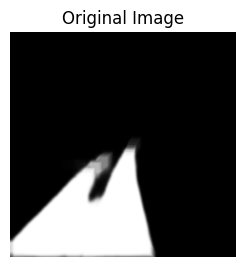

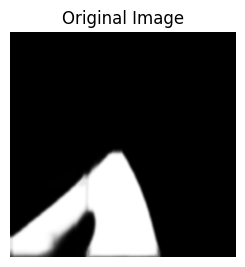

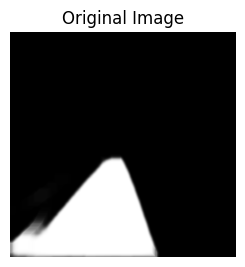

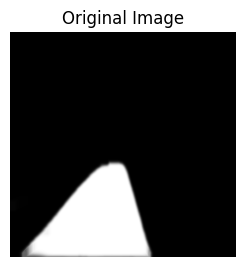

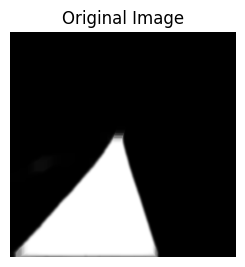

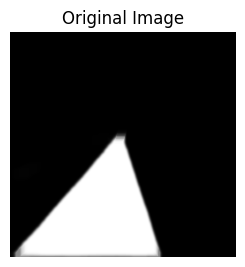

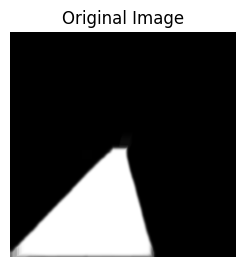

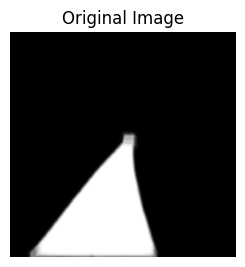

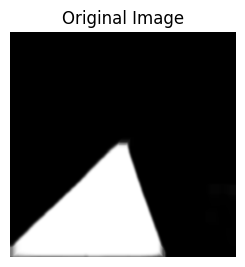

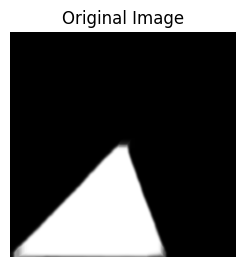

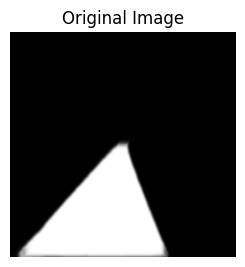

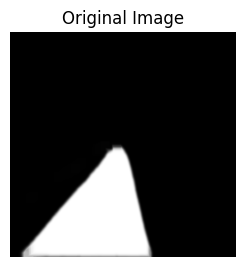

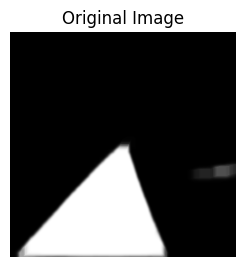

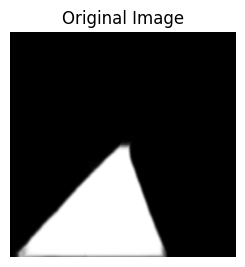

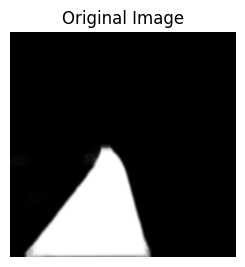

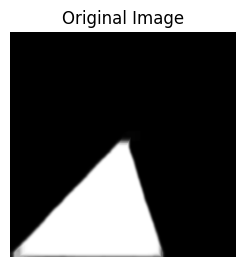

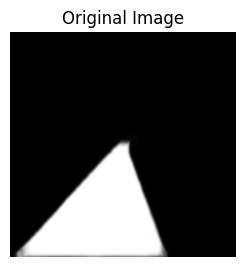

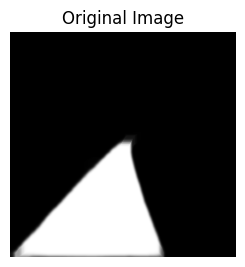

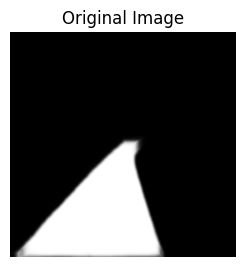

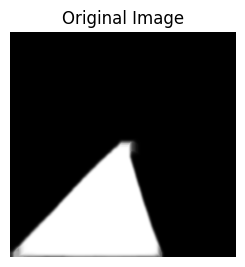

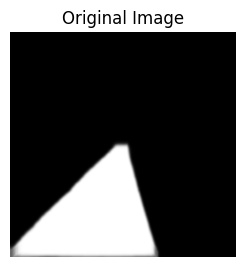

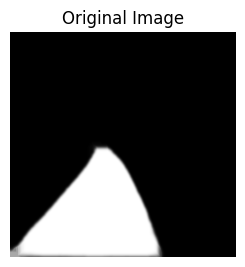

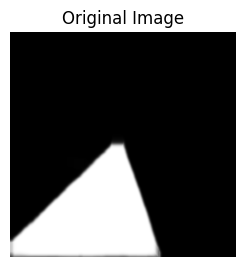

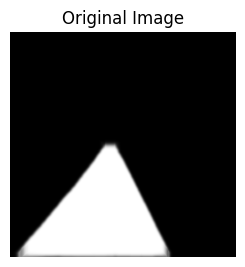

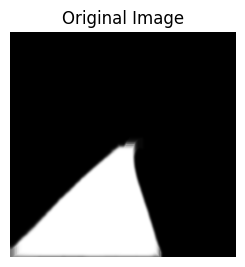

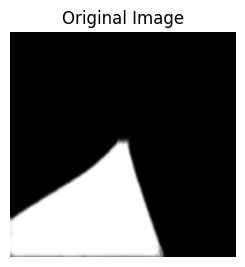

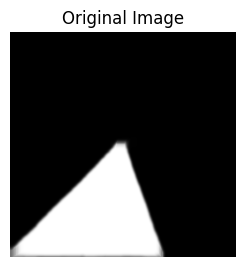

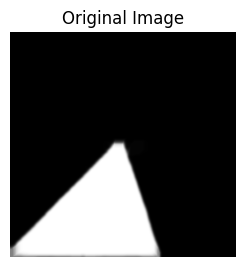

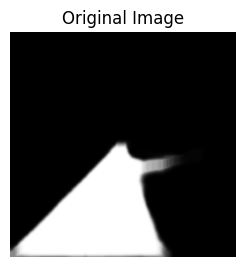

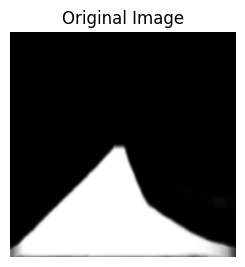

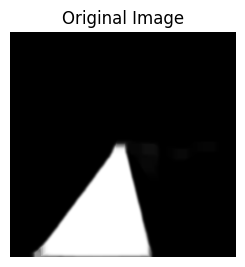

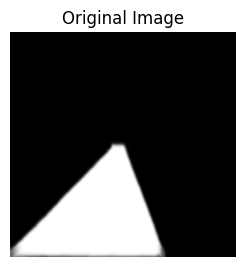

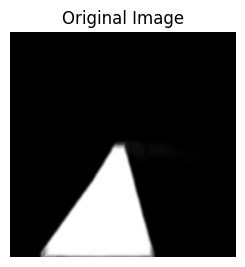

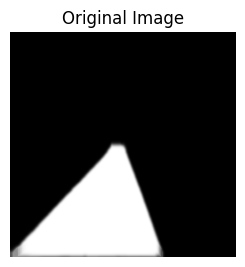

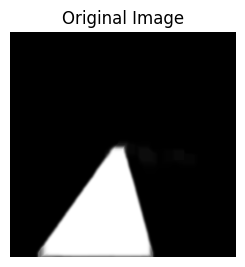

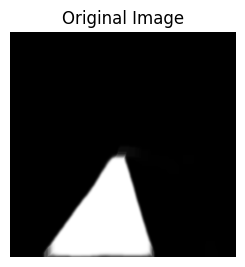

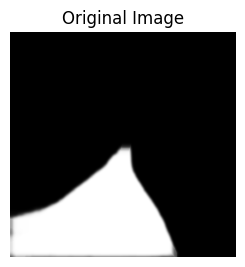

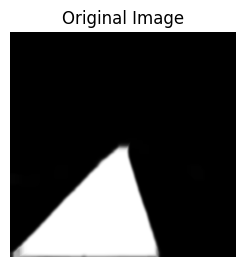

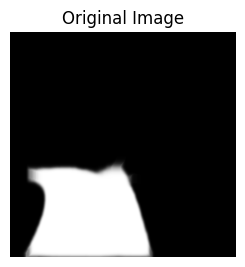

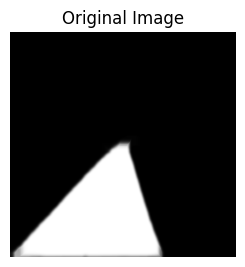

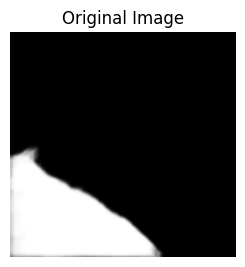

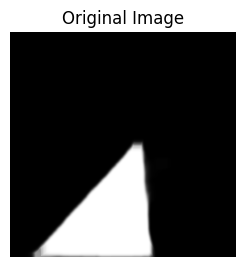

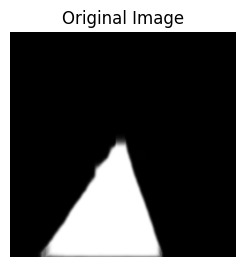

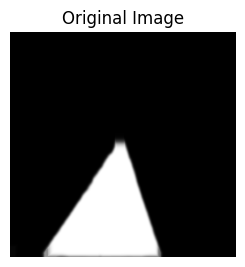

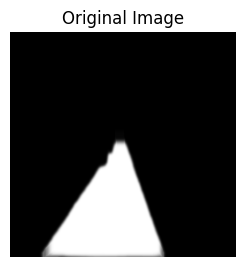

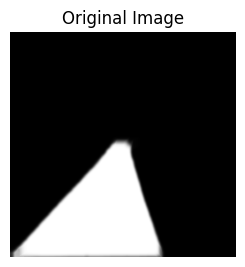

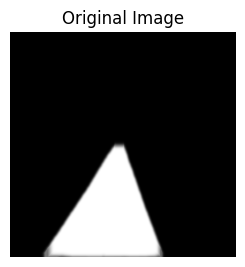

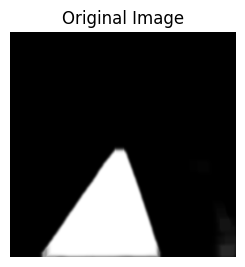

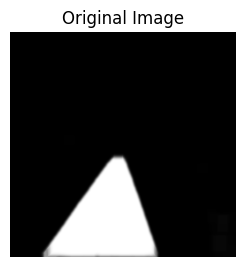

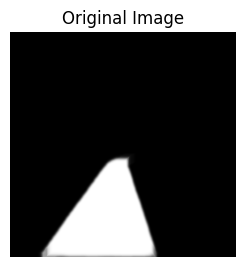

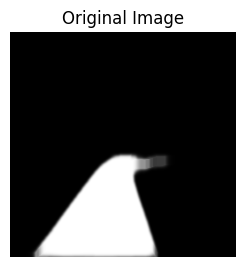

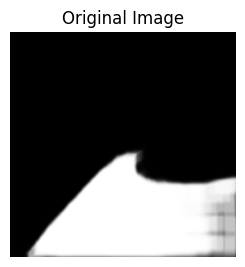

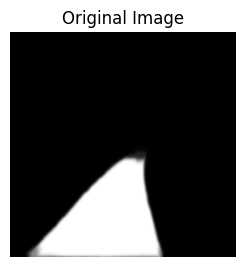

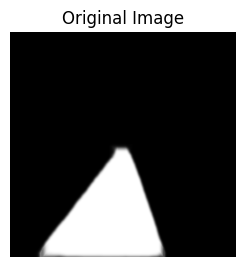

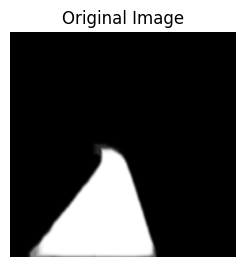

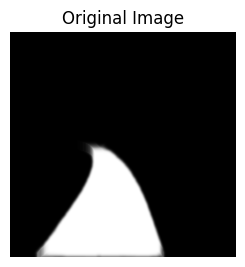

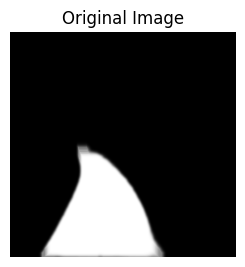

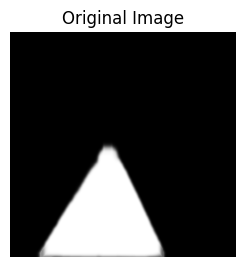

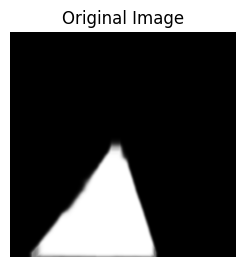

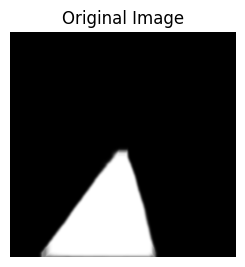

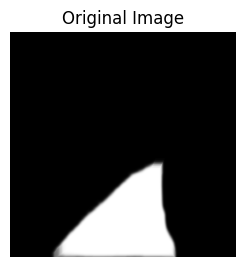

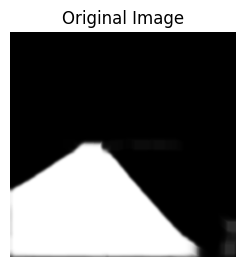

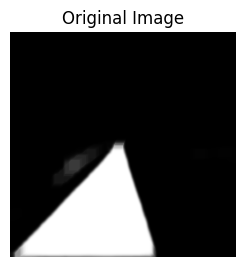

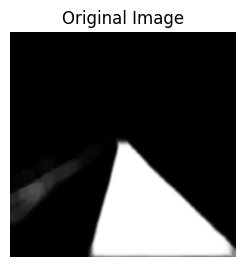

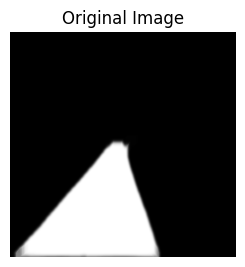

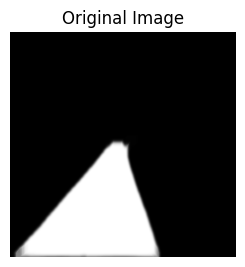

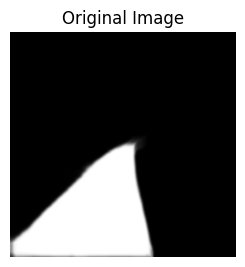

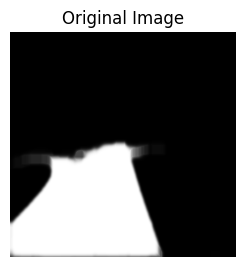

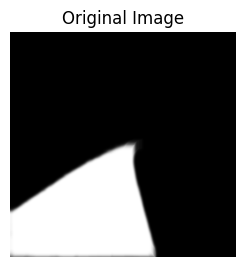

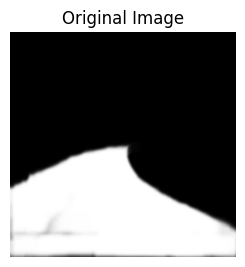

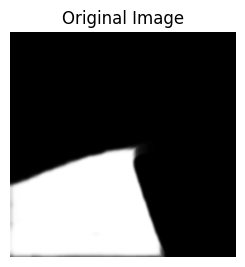

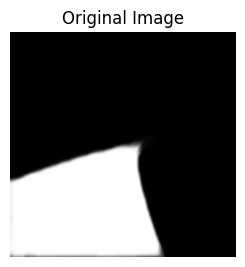

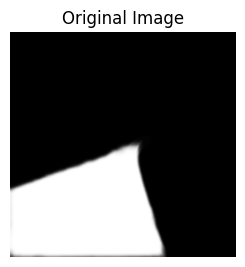

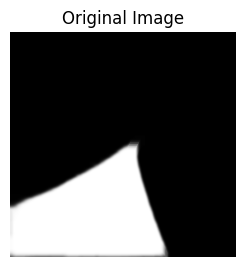

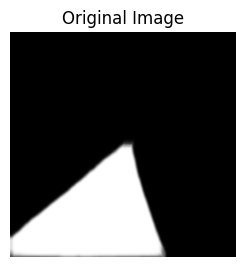

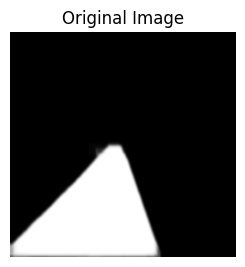

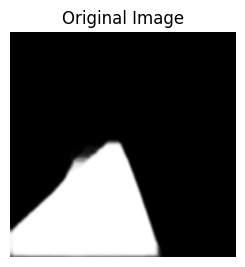

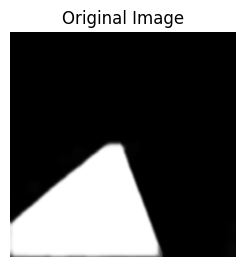

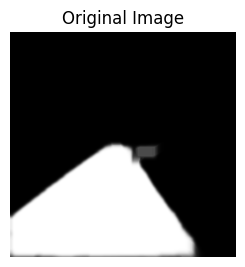

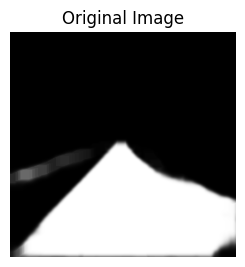

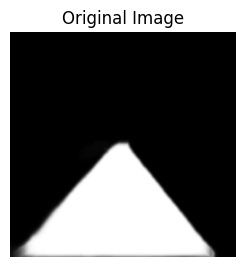

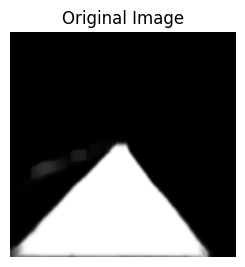

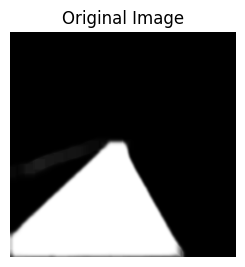

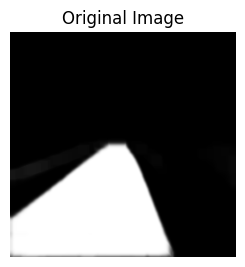

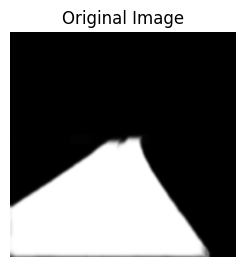

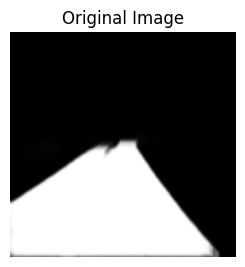

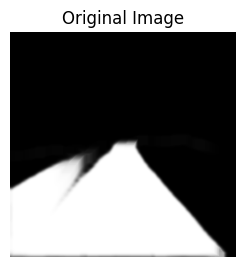

In [25]:

N = 100

#reset generator
train_generator.reset()

count = 0
for original_batch, _ in train_generator:
    for j in range(original_batch.shape[0]):
        if count >= N:
            break

        original_img = original_batch[j]
        
        #plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.show()

        count += 1
    if count >= N:
        break 

In [7]:
# Define early stopping callback
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Now include the callback in the fit method
autoencoder.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[early_stopper],
    shuffle = True
)

Epoch 1/60


/Users/yong/anaconda3/envs/plard/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - loss: 0.2428 - val_loss: 0.2372
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.2359 - val_loss: 0.2305
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.2280 - val_loss: 0.2219
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 383ms/step - loss: 0.2185 - val_loss: 0.2114
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 387ms/step - loss: 0.2058 - val_loss: 0.1999
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.1954 - val_loss: 0.1888
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.1828 - val_loss: 0.1741
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.1637 - val_loss: 0.1528
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - loss: 0.1467 - val_loss: 0.1291
Epoch 10/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 394ms/step - loss: 0.1203 - val_loss: 0.0994
Epoch 11/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.0910 - val_loss: 0.0677
Epoch 12/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - loss: 0.0591 - val_loss: 0.0380


In [8]:
#save model
autoencoder.save('goodmodel.keras')

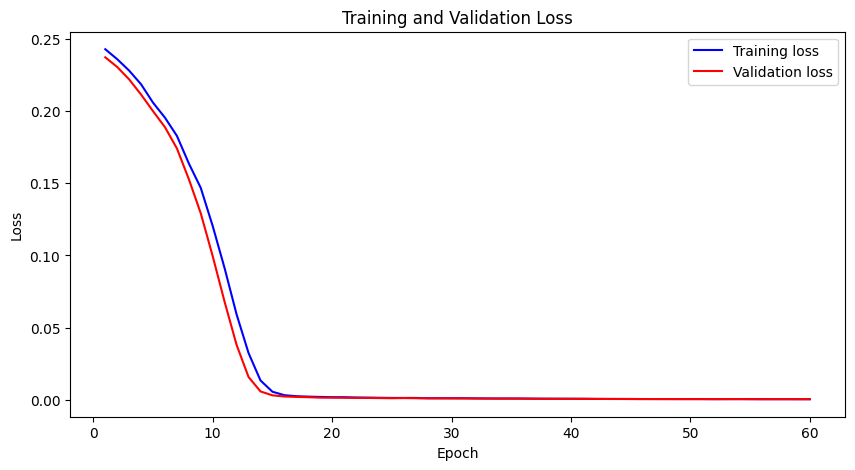

In [2]:


# Given loss and validation loss values from the output message
loss = [
    0.2428, 0.2359, 0.2280, 0.2185, 0.2058, 0.1954, 0.1828, 0.1637, 0.1467, 0.1203,
    0.0910, 0.0591, 0.0324, 0.0134, 0.0056, 0.0032, 0.0025, 0.0022, 0.0020, 0.0018,
    0.0018, 0.0016, 0.0015, 0.0014, 0.0013, 0.0013, 0.0013, 0.0011, 0.0011, 0.0011,
    0.0011, 0.0010, 0.0009266, 0.0008948, 0.0009232, 0.0008869, 0.0007879, 0.0007559,
    0.0007472, 0.0007489, 0.0007207, 0.0006362, 0.0006111, 0.0006026, 0.0005813,
    0.0005406, 0.0005256, 0.0005375, 0.0005041, 0.0005206, 0.0005054, 0.0004489,
    0.0004696, 0.0004793, 0.0004867, 0.0004474, 0.0004377, 0.0004406, 0.0004219,
    0.0004371
]

val_loss = [
    0.2372, 0.2305, 0.2219, 0.2114, 0.1999, 0.1888, 0.1741, 0.1528, 0.1291, 0.0994,
    0.0677, 0.0380, 0.0158, 0.0058, 0.0031, 0.0023, 0.0020, 0.0018, 0.0015, 0.0015,
    0.0014, 0.0013, 0.0013, 0.0012, 0.0011, 0.0012, 0.0011, 0.0010, 0.0009836, 0.0009669,
    0.0009322, 0.0008844, 0.0008737, 0.0008291, 0.0007919, 0.0007784, 0.0007449, 0.0006996,
    0.0006899, 0.0006457, 0.0006349, 0.0006173, 0.0005762, 0.0005565, 0.0005366, 0.0005228,
    0.0005141, 0.0004905, 0.0004937, 0.0004698, 0.0004767, 0.0004723, 0.0004888, 0.0005011,
    0.0004397, 0.0004199, 0.0004255, 0.0004325, 0.0004218, 0.0004072
]

# Generating a plot of the training and validation loss
epochs = range(1, 61)  # 60 epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
